In [19]:
import pandas as pd
import numpy as np

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [21]:
from parallel_ica import perform_fastica, inverse_fastica

In [22]:
from scipy.io import wavfile

srate, dataBach = wavfile.read('../data/bach.wav')
_, dataSpeech = wavfile.read('../data/speech.wav')

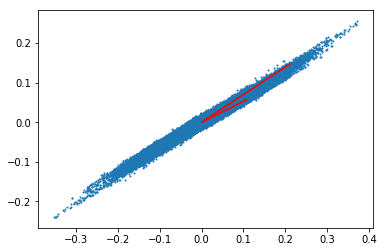

In [23]:
import numpy as np

def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

gtruthS = audionorm([dataBach, dataSpeech])

def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

def drawDataWithMixingMatrix(data, mat):
    # plot data points
    plt.scatter(data[0], data[1], s=1)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')
    
X, gtruthA = simpleMixer(gtruthS)
drawDataWithMixingMatrix(X, gtruthA)

In [24]:
def compareMixingMatrix(data, matA, matB):
    plt.figure(figsize=(16, 8))
    # plot first mixing matrix
    plt.subplot(1,2,1)
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    plt.subplot(1,2,2)
    drawDataWithMixingMatrix(data, matB)

In [25]:
A, S, X_mean = perform_fastica(X, n_components=2)

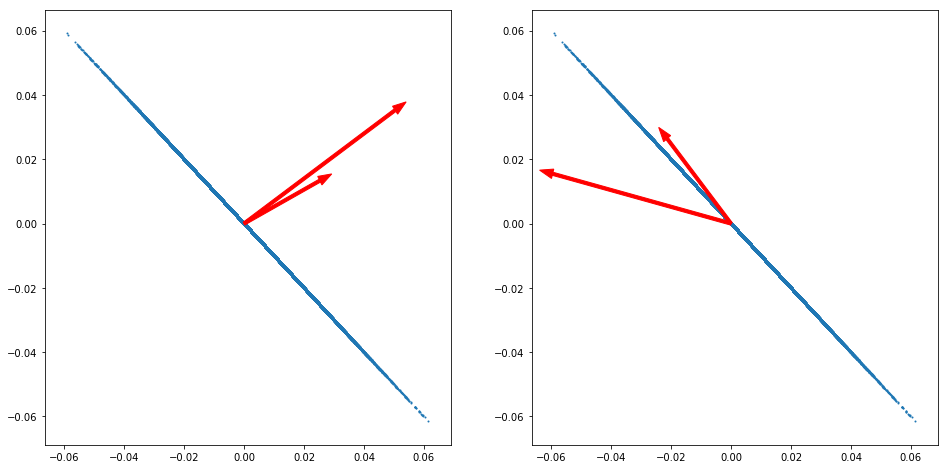

In [32]:
compareMixingMatrix(X, gtruthA, S)

In [27]:
A

array([[ 0.18975004,  0.02179344],
       [-0.00351193, -0.00040336],
       [-0.00337811, -0.00038799],
       ...,
       [-0.02290494, -0.00263071],
       [-0.01848791, -0.0021234 ],
       [-0.01468924, -0.00168711]])

In [28]:
gtruthA

array([[0.39882637, 0.79506323],
       [0.21036049, 0.55611523]])

In [29]:
A.shape

(132362, 2)

In [30]:
S.shape

(2, 2)

In [31]:
S

array([[-0.53827286, -1.50335693],
       [ 0.6668396 ,  0.39086914]])